In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv('trainMA.csv')
test = pd.read_csv('testMA.csv')

In [3]:
train = train.rename(columns={'Unnamed: 0': 'date_forecast'})

In [4]:
train.set_index('date_forecast', inplace=True)
test.set_index('date_forecast', inplace=True)
train.index = pd.to_datetime(train.index)


In [5]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train['is_est'] = 0
train['is_est'].iloc[-4418:] = 1


C:\Users\claxl\AppData\Local\Temp\ipykernel_61052\2428353307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_est'].iloc[-4418:] = 1


In [6]:
nan_col = ['snow_densitykgm3','ceiling_height_aglm','cloud_base_aglm']
for col in nan_col:
    
    test[col] = test[col].fillna(0)
    train[col] = train[col].fillna(train[col].median())

train=train.dropna()
test=test.dropna()

In [17]:
train.isna().mean()

absolute_humidity_2mgm3        0.0
air_density_2mkgm3             0.0
ceiling_height_aglm            0.0
clear_sky_energy_1hJ           0.0
clear_sky_radW                 0.0
                              ... 
wind_speed_w_1000hPams_sqrt    0.0
minute_sqrt                    0.0
hour_sqrt                      0.0
month_sqrt                     0.0
is_est_sqrt                    0.0
Length: 99, dtype: float64

In [8]:
train.columns

Index(['absolute_humidity_2mgm3', 'air_density_2mkgm3', 'ceiling_height_aglm',
       'clear_sky_energy_1hJ', 'clear_sky_radW', 'cloud_base_aglm',
       'dew_or_rimeidx', 'dew_point_2mK', 'diffuse_radW', 'diffuse_rad_1hJ',
       'direct_radW', 'direct_rad_1hJ', 'effective_cloud_coverp', 'elevationm',
       'fresh_snow_12hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm',
       'fresh_snow_3hcm', 'fresh_snow_6hcm', 'is_dayidx', 'is_in_shadowidx',
       'msl_pressurehPa', 'precip_5minmm', 'precip_type_5minidx',
       'pressure_100mhPa', 'pressure_50mhPa', 'prob_rimep', 'rain_waterkgm2',
       'relative_humidity_1000hPap', 'sfc_pressurehPa', 'snow_densitykgm3',
       'snow_depthcm', 'snow_driftidx', 'snow_melt_10minmm', 'snow_waterkgm2',
       'sun_azimuthd', 'sun_elevationd', 'super_cooled_liquid_waterkgm2',
       't_1000hPaK', 'total_cloud_coverp', 'visibilitym', 'wind_speed_10mms',
       'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams',
       'minute', 'hour', 

In [9]:
train.shape, test.shape

((34061, 50), (720, 48))

In [10]:
train['pv_measurement'] = train['pv_measurement'].mask(train['is_in_shadowidx'] == 1, 0)


<Axes: xlabel='date_forecast'>

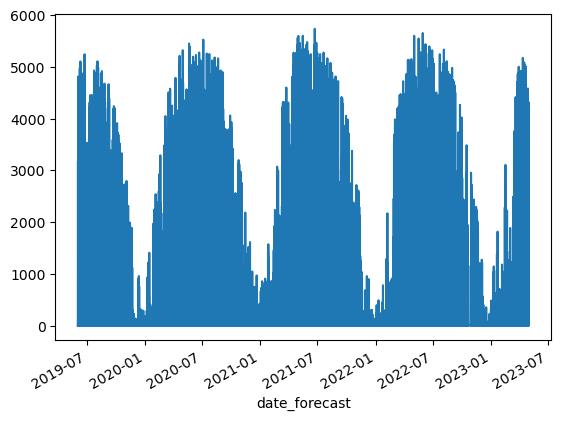

In [11]:
train['pv_measurement'].plot()

In [12]:
def transform(df):
    for col in df.columns:
        if col == 'pv_measurement':
            df['pv_measurement'] = np.sqrt(df['pv_measurement'])
            continue
        new_col_name = col + "_sqrt"
        df[new_col_name] = np.sqrt(df[col])

    return df

In [13]:
train = transform(train)
test = transform(test)

C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\claxl\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sq

In [14]:
train.shape,test.shape

((34061, 99), (720, 96))

In [15]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

In [21]:
train['hours'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month
train['year'] = train.index.year
train['dayofyear'] = train.index.dayofyear

In [22]:
test['hours'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month
test['year'] = test.index.year
test['dayofyear'] = test.index.dayofyear

In [23]:
# Supponiamo che "gruppi" sia il risultato della suddivisione
gruppi = train.groupby('is_est')

# Itera attraverso i gruppi e crea un DataFrame separato per ciascun gruppo
dataframes_per_gruppo = {}
for valore, gruppo in gruppi:
    dataframes_per_gruppo[valore] = gruppo.copy()
train_set = dataframes_per_gruppo[0]
val_set = dataframes_per_gruppo[1]

In [26]:
train = train.fillna(0)
test = test.fillna(0)

In [29]:
train

,absolute_humidity_2mgm3,air_density_2mkgm3,ceiling_height_aglm,clear_sky_energy_1hJ,clear_sky_radW,cloud_base_aglm,dew_or_rimeidx,dew_point_2mK,diffuse_radW,diffuse_rad_1hJ,...,wind_speed_u_10mms_sqrt,wind_speed_v_10mms_sqrt,wind_speed_w_1000hPams_sqrt,minute_sqrt,hour_sqrt,month_sqrt,hours,day,year,dayofyear
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-06-02 22:00:00,7.70,1.2285,1728.750000,0.000000,0.00,1728.750000,0.0,280.299988,0.0,0.000000,...,0.000000,0.000000,-0.0,4.743416,4.690416,2.44949,22,2,2019,153
2019-06-02 23:00:00,7.70,1.2235,1689.649963,0.000000,0.00,1689.649963,0.0,280.299988,0.0,0.000000,...,0.000000,0.547723,-0.0,4.743416,4.795832,2.44949,23,2,2019,153
2019-06-03 00:00:00,7.85,1.2195,1563.250000,0.000000,0.00,1563.250000,0.0,280.649994,0.0,0.000000,...,0.000000,0.866025,-0.0,4.743416,0.000000,2.44949,0,3,2019,154
2019-06-03 01:00:00,8.45,1.2180,1283.400024,0.000000,0.00,1283.400024,0.0,281.699997,0.0,0.000000,...,0.000000,0.948683,-0.0,4.743416,1.000000,2.44949,1,3,2019,154
2019-06-03 02:00:00,8.95,1.2180,1003.500000,28421.850586,21.95,1003.500000,0.0,282.500000,11.4,20473.800293,...,0.000000,0.948683,-0.0,4.743416,1.414214,2.44949,2,3,2019,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 19:00:00,4.55,1.2765,1674.200012,77243.597656,1.70,542.699982,0.0,272.449997,1.2,51847.349609,...,2.190890,1.396424,-0.0,4.743416,4.358899,2.00000,19,30,2023,120
2023-04-30 20:00:00,4.50,1.2800,1762.400024,474.799988,0.00,546.399994,0.0,272.299988,0.0,2152.050049,...,2.012461,1.516575,-0.0,4.743416,4.472136,2.00000,20,30,2023,120
2023-04-30 21:00:00,4.50,1.2810,1696.650024,0.000000,0.00,548.350006,0.0,272.299988,0.0,0.000000,...,1.884144,1.612452,-0.0,4.743416,4.582576,2.00000,21,30,2023,120


In [40]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]


In [41]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'n_jobs' : [-1]
             }
print(param_grid)

{'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_features': ['log2', 'sqrt', None], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False], 'n_jobs': [-1]}


In [42]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rf_Model = RandomForestRegressor()

y_train = train['pv_measurement']
X_train = train.drop(columns = 'pv_measurement')
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 42, 74, 106, 138,
                                                         171, 203, 235, 267,
                                                         300],
                                        'n_jobs': [-1]},
                   verbose=2)

In [43]:
model_A = RandomForestRegressor(**rf_RandomGrid.best_params_)

In [44]:
X_train = train.drop(columns = 'pv_measurement')
y_train = train['pv_measurement']

In [45]:
model_A.fit(X_train,y_train)
y_pred_A = model_A.predict(test)

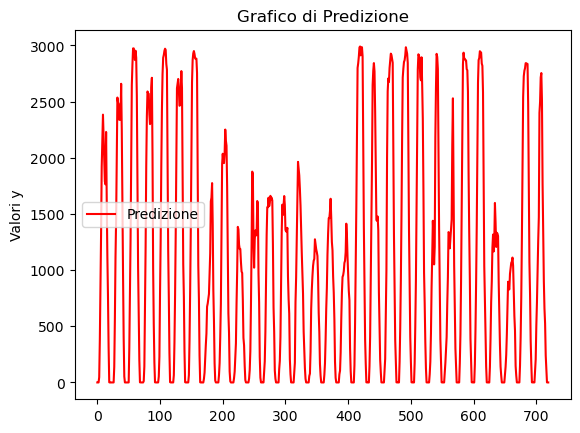

In [46]:
plt.plot(range(len(y_pred_A)), (y_pred_A)**2, label='Predizione', color='red', linestyle='-')
# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [47]:
df = pd.DataFrame({'Prediction':y_pred_A**2})

In [48]:
test = test.reset_index()
df.loc[test['is_in_shadowidx'] == 1, 'Prediction'] = 0


In [49]:
df.to_csv('A1.csv')

In [50]:
df

,Prediction
0,0.000000
1,0.000000
2,0.000000
3,47.280658
4,377.897418
...,...
715,239.384269
716,114.054976
717,0.000000
718,0.000000


In [ ]:
rf_RandomGrid.best_params_